In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [2]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        """Reads a CSV file into the dataframe."""
        if os.path.exists(file_name):
            self.dataframe = pd.read_csv(file_name)
            print(f"Data successfully read from {file_name}.")
        else:
            print(f"Error: The file {file_name} does not exist.")

    def check_null_values(self):
        """Checks for null values in the dataframe."""
        print("Null Values Before Cleaning:")
        print(self.dataframe.isnull().sum())

    def clean_data(self):
        """Removes null values from the dataframe."""
        initial_shape = self.dataframe.shape
        self.dataframe.dropna(inplace=True)
        final_shape = self.dataframe.shape
        print(f"Data cleaned: {initial_shape[0] - final_shape[0]} rows removed.")

    def print_head(self):
        """Prints the head of the dataframe."""
        print("Head of the DataFrame:")
        print(self.dataframe.head())

    def print_description(self):
        """Prints the description of the dataframe."""
        print("\nDescription of the DataFrame:")
        print(self.dataframe.describe())

    def normalize(self):
        """Normalizes numeric columns in the dataframe."""
        numeric_cols = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.scaler = MinMaxScaler()
        self.dataframe[numeric_cols] = self.scaler.fit_transform(self.dataframe[numeric_cols])
        print(f"Data normalized for columns: {numeric_cols.tolist()}")

    def visualize_open(self):
        """Plots graph for open stock values vs. date."""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y='Open')
            plt.title('Open Stock Values over the Years')
            plt.xlabel('Year')
            plt.ylabel('Open Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and 'Open' columns.")

    def visualize_close(self):
        """Plots graph for close stock values vs. data."""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y='Close')
            plt.title('Close Stock Values over the Years')
            plt.xlabel('Year')
            plt.ylabel('Close Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and 'Close' columns.")      

In [3]:
data = Data()

In [4]:
data.read('AMBUJACEM.csv')


Data successfully read from AMBUJACEM.csv.


In [5]:
data.check_null_values()

Null Values Before Cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
data.clean_data()

Data cleaned: 0 rows removed.


In [7]:
data.print_head()

Head of the DataFrame:
         Date        Open        High         Low       Close  Adj Close  \
0  2009-05-29   89.849998   93.949997   89.099998   91.599998  70.553879   
1  2009-06-01   92.000000   98.699997   92.000000   98.050003  75.521942   
2  2009-06-02  104.400002  105.699997   99.449997  100.349998  77.293488   
3  2009-06-03   99.250000  106.000000   99.250000  105.150002  80.990623   
4  2009-06-04  104.000000  105.150002  100.750000  101.949997  78.525841   

    Volume  
0  2974882  
1  4224333  
2  5825369  
3  2895498  
4  3247248  


In [8]:
data.print_description()


Description of the DataFrame:
              Open         High          Low        Close    Adj Close  \
count  3700.000000  3700.000000  3700.000000  3700.000000  3700.000000   
mean    245.292108   248.823311   241.510189   245.098716   223.574216   
std     113.563837   114.883473   111.692580   113.265552   121.174804   
min      84.099998    84.699997    81.849998    82.449997    64.213791   
25%     177.874996   180.287502   174.287502   177.250004   150.855114   
50%     215.000000   218.424995   212.025002   214.974998   190.128662   
75%     269.200005   272.962509   265.324989   269.025002   242.463024   
max     648.000000   656.950012   635.099976   646.500000   646.500000   

             Volume  
count  3.700000e+03  
mean   3.577972e+06  
std    4.912518e+06  
min    0.000000e+00  
25%    1.557490e+06  
50%    2.378198e+06  
75%    3.948111e+06  
max    9.103571e+07  


In [9]:
data.normalize()

Data normalized for columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


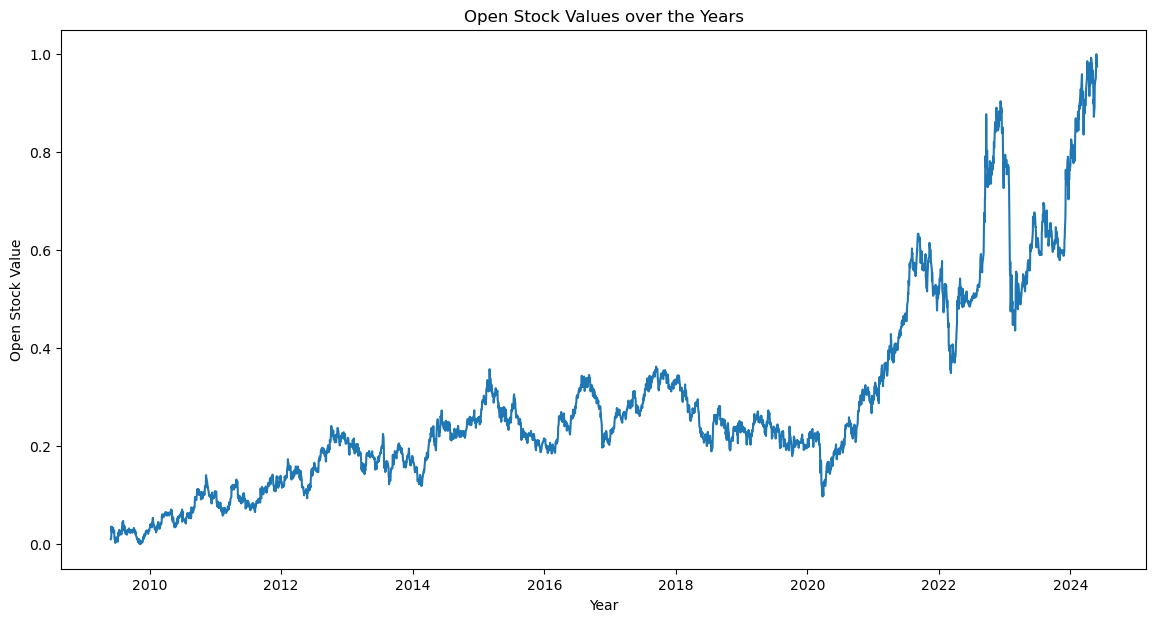

In [10]:
data.visualize_open()

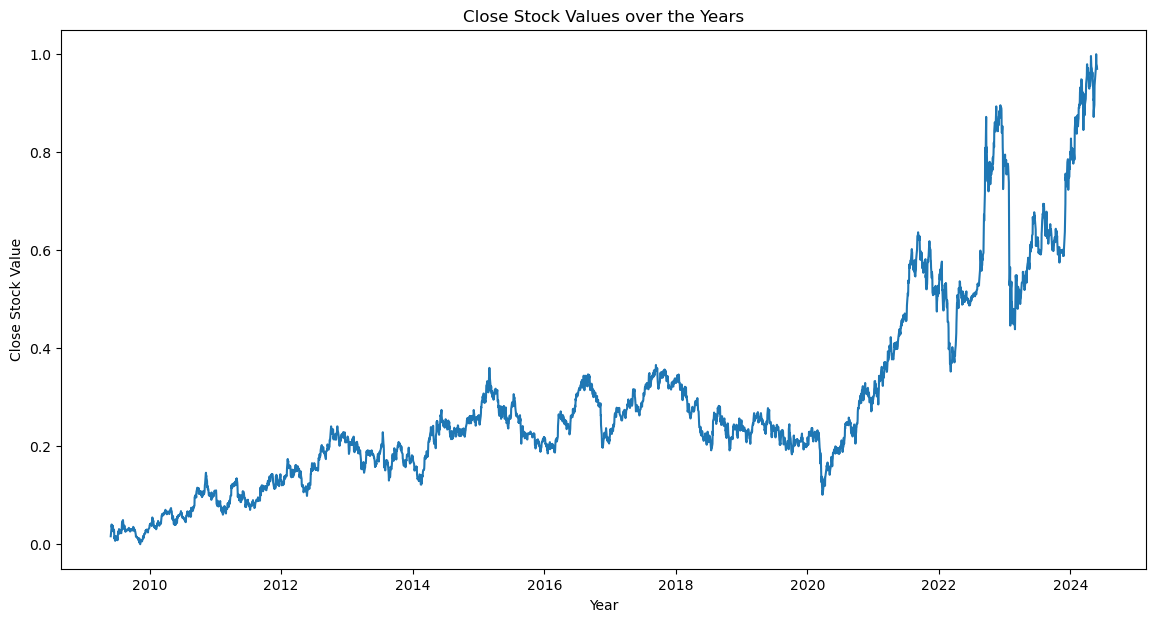

In [11]:
data.visualize_close()

In [12]:
class LSTM_Trainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data(self, feature_col = 'Close', look_back = 60):
        """Prepare data for lstm"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)
       
        x = [] 
        y = [] 
  
        for i in range(len(data) - look_back): 
            x.append(data[i:i + look_back]) 
            y.append(data[i + look_back]) 
  
        x, y = np.array(x), np.array(y) 

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
        return x_train, x_test, y_train, y_test.reshape(-1, 1)


    def build_and_train_lstm(self, feature_col = 'Close', look_back = 60, epochs = 200, batch_size = 16):
        """Build and train the lstm model"""
        x_train, x_test, y_train, y_test = self.prepare_data(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1)))
        model.add(LSTM(units = 50))
        model.add(Dense(1))

        model.compile(optimizer = 'adam', loss = 'mean_squared_error') 
        
        model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test)) 

        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.x_test)
        predictions = predictions.reshape(-1, 1)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.fit(self.dataframe['Close'].values.reshape(-1, 1)) 
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        plt.figure(figsize = (14, 7))
        plt.plot(actual, label = 'Actual Stock Price')
        plt.plot(predictions, label = 'Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show() 
        
    def evaluate_model(self):
        """Evaluating the model"""
        predictions = self.model.predict(self.x_test)
        predictions = self.scaler.inverse_transform(predictions)
        actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1))

        mse = mean_squared_error(actual, predictions)
        mae = mean_absolute_error(actual, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(actual, predictions)
        
        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"Root Mean Squared Error: {rmse}")
        print(f"R-squared: {r2}")

In [13]:
trainer = LSTM_Trainer(data.dataframe, data.scaler)

In [14]:
trainer.build_and_train_lstm()

Epoch 1/200


C:\Users\rbavi\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 2/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.6510e-04 - val_loss: 0.0016
Epoch 3/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.1074e-04 - val_loss: 0.0019
Epoch 4/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.7756e-04 - val_loss: 0.0015
Epoch 5/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.6340e-04 - val_loss: 0.0011
Epoch 6/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.4235e-04 - val_loss: 8.9574e-04
Epoch 7/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.6805e-04 - val_loss: 7.1909e-04
Epoch 8/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.2769e-04 - val_loss: 6.3151e-04
Epoch 9/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0771e-04 - val_loss: 5.9789e-04
Epoch 10/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.0312e-04 - val_loss: 4.5094e-04
Epoch 11/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0374e-04 -

Epoch 64/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.8747e-05 - val_loss: 3.7907e-04
Epoch 65/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.2557e-05 - val_loss: 3.4090e-04
Epoch 66/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.4521e-05 - val_loss: 3.1660e-04
Epoch 67/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.3628e-05 - val_loss: 3.7588e-04
Epoch 68/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.4820e-05 - val_loss: 3.1224e-04
Epoch 69/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.6830e-05 - val_loss: 3.1574e-04
Epoch 70/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.7880e-05 - val_loss: 3.1683e-04
Epoch 71/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.5866e-05 - val_loss: 3.3573e-04
Epoch 72/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.9954e-05 - val_loss: 5.0501e-04
Epoch 73/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.9904e-05 - val_loss: 3.1103e-04
Epoch 74/200
182/182 ━━━━━━━━━

182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 4.8615e-05 - val_loss: 3.8804e-04
Epoch 127/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 5.0905e-05 - val_loss: 6.3567e-04
Epoch 128/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5.1332e-05 - val_loss: 4.2723e-04
Epoch 129/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 5.1002e-05 - val_loss: 3.4325e-04
Epoch 130/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 4.5893e-05 - val_loss: 3.4311e-04
Epoch 131/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 4.5621e-05 - val_loss: 4.6204e-04
Epoch 132/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 4.9776e-05 - val_loss: 3.7111e-04
Epoch 133/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 4.7667e-05 - val_loss: 3.3518e-04
Epoch 134/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5.0278e-05 - val_loss: 3.3986e-04
Epoch 135/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 4.9418e-05 - val_loss: 3.3666e-04
Epoch 136/200
182/182 ━━━━━━━━━━━━

182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 5.0249e-05 - val_loss: 3.6235e-04
Epoch 189/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 4.9133e-05 - val_loss: 3.5948e-04
Epoch 190/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 5.2894e-05 - val_loss: 3.4464e-04
Epoch 191/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 4.6841e-05 - val_loss: 3.5138e-04
Epoch 192/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 5.2075e-05 - val_loss: 3.9346e-04
Epoch 193/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 4.5511e-05 - val_loss: 3.8955e-04
Epoch 194/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4.9639e-05 - val_loss: 3.8902e-04
Epoch 195/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 4.8205e-05 - val_loss: 3.6856e-04
Epoch 196/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 4.9269e-05 - val_loss: 4.1114e-04
Epoch 197/200
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 4.6530e-05 - val_loss: 3.5981e-04
Epoch 198/200
182/182 ━━━━━━━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


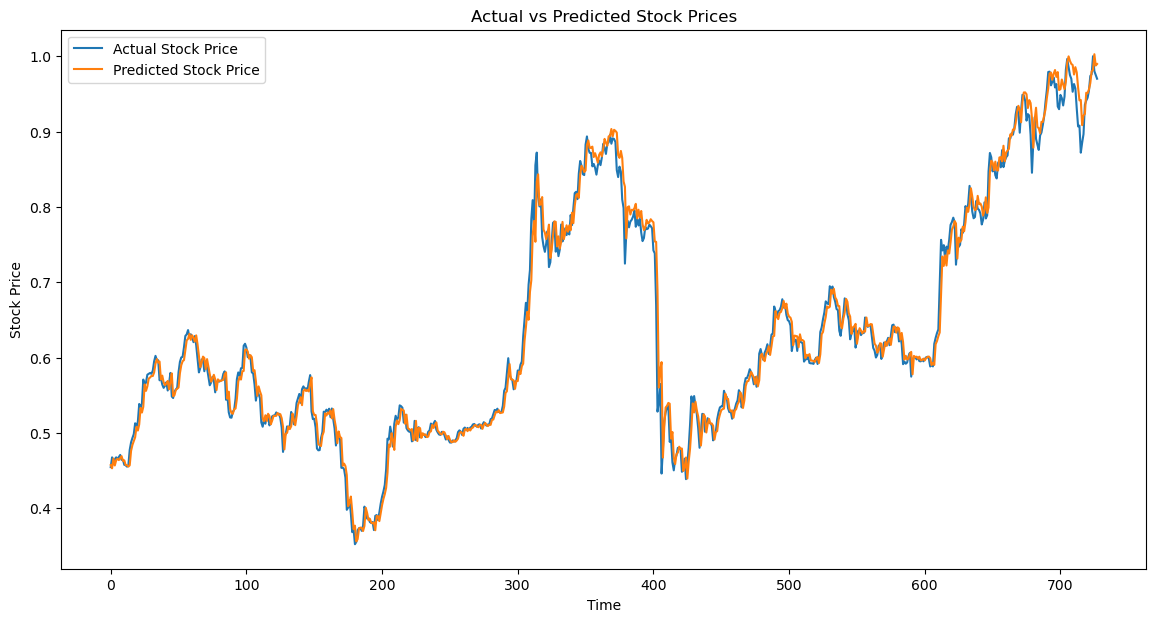

In [15]:
trainer.predict_and_plot()

In [16]:
trainer.evaluate_model()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Squared Error: 0.0003804598953865558
Mean Absolute Error: 0.0124803900166629
Root Mean Squared Error: 0.019505381190496017
R-squared: 0.9834672071940342


In [17]:
with open('stock_model.pkl','wb') as file:
  pickle.dump(trainer,file)
print("Model saved to stock_model.pkl.")


Model saved to stock_model.pkl.


In [18]:

with open('stock_model.pkl','rb') as file:
  trained_model = pickle.load(file)
print("Model loaded from stock_model.pkl}.")

Model loaded from stock_model.pkl}.
